In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from malid import config, helpers, io
from malid.datamodels import TargetObsColumnEnum
import gc
from kdict import kdict
from IPython.display import display
import itertools
import random
import genetools

# Overlapping sequences between folds

In [2]:
sequence_identifying_cols = [
    "v_gene",
    "j_gene",
    "isotype_supergroup",
    "cdr1_seq_aa_q_trim",
    "cdr2_seq_aa_q_trim",
    "cdr3_seq_aa_q_trim",
]
pd.set_option("display.max_columns", 100)
config.gene_loci_used

<GeneLocus.BCR|TCR: 3>

In [3]:
for gene_locus in config.gene_loci_used:
    fold_details = kdict()
    # use cross validation folds only - because we want to make claims about our cross validation splits:
    for fold_id in config.cross_validation_fold_ids:
        for fold_label in ["train_smaller", "validation", "test"]:
            adata = io.load_fold_embeddings(
                fold_id=fold_id,
                fold_label=fold_label,
                gene_locus=gene_locus,
                target_obs_column=TargetObsColumnEnum.disease,
            )
            df = adata.obs

            n_sequences = df.shape[0]

            participants = set(df["participant_label"].unique())
            n_participants = len(participants)

            specimens = set(df["specimen_label"].unique())
            n_specimens = len(specimens)

            sequences_only = df[sequence_identifying_cols].drop_duplicates()
            n_unique_sequences = sequences_only.shape[0]

            # Slower alternatives, according to %timeit:
            # df.head().apply(joblib.hash, axis=1)
            # sequences_only.head().apply(lambda x: hash(tuple(x)), axis = 1)
            hashed_sequences = pd.util.hash_pandas_object(sequences_only, index=False)

            unique_sequence_hashes = set(hashed_sequences)

            if len(unique_sequence_hashes) != sequences_only.shape[0]:
                raise ValueError("Hash collision")

            fold_details[fold_id, fold_label] = {
                "fold_id": fold_id,
                "fold_label": fold_label,
                "n_sequences": n_sequences,
                "participants": participants,
                "n_participants": n_participants,
                "specimens": specimens,
                "n_specimens": n_specimens,
                "n_unique_sequences": n_unique_sequences,
                "unique_sequence_hashes": unique_sequence_hashes,
            }

            del sequences_only, hashed_sequences, unique_sequence_hashes, df, adata
            io.clear_cached_fold_embeddings()
            gc.collect()

    comparison_data = []
    for fold_id in fold_details.keys(dimensions=0):
        for fold_label1, fold_label2 in itertools.combinations(
            fold_details[fold_id, :].keys(dimensions=1), 2
        ):
            data1 = fold_details[fold_id, fold_label1]
            data2 = fold_details[fold_id, fold_label2]

            unique_sequence_hashes1 = data1["unique_sequence_hashes"]
            unique_sequence_hashes2 = data2["unique_sequence_hashes"]

            comparison_data.append(
                {
                    "fold_id": fold_id,
                    "fold_label1": fold_label1,
                    "fold_label2": fold_label2,
                    "n_sequences1": data1["n_sequences"],
                    "n_sequences2": data2["n_sequences"],
                    "n_participants1": data1["n_participants"],
                    "n_participants2": data2["n_participants"],
                    "n_specimens1": data1["n_specimens"],
                    "n_specimens2": data2["n_specimens"],
                    "n_unique_sequences1": data1["n_unique_sequences"],
                    "n_unique_sequences2": data2["n_unique_sequences"],
                    "n_overlapping_participants": len(
                        data1["participants"].intersection(data2["participants"])
                    ),
                    "n_overlapping_specimens": len(
                        data1["specimens"].intersection(data2["specimens"])
                    ),
                    "n_overlapping_unique_sequence_hashes": len(
                        unique_sequence_hashes1.intersection(unique_sequence_hashes2)
                    ),
                    "jaccard_index_unique_sequence_hashes": float(
                        len(
                            unique_sequence_hashes1.intersection(
                                unique_sequence_hashes2
                            )
                        )
                    )
                    / len(unique_sequence_hashes1.union(unique_sequence_hashes2)),
                }
            )
    comparison_data = pd.DataFrame(comparison_data)
    display(comparison_data)
    print(
        f"{gene_locus}: Average overlap Jaccard index between any two fold labels from the same fold ID: {np.mean(comparison_data['jaccard_index_unique_sequence_hashes'] * 100):0.3f}%"
    )
    print(
        f"{gene_locus}: Average +/- std overlap Jaccard index between any two fold labels from the same fold ID: {np.mean(comparison_data['jaccard_index_unique_sequence_hashes'] * 100):0.3f} +/- {np.std(comparison_data['jaccard_index_unique_sequence_hashes'] * 100):0.3f} %"
    )
    comparison_data.to_csv(
        config.paths.output_dir / f"fold_sequence_overlap_stats.{gene_locus.name}.tsv",
        sep="\t",
        index=None,
    )

    ### Sanity check: compare across folds - should get dupes
    comparison_data_sanity_check = []
    for key1, key2 in itertools.combinations(fold_details.keys(), 2):
        data1 = fold_details[key1]
        data2 = fold_details[key2]

        unique_sequence_hashes1 = data1["unique_sequence_hashes"]
        unique_sequence_hashes2 = data2["unique_sequence_hashes"]

        comparison_data_sanity_check.append(
            {
                "fold_id1": key1[0],
                "fold_id2": key2[0],
                "fold_label1": key1[1],
                "fold_label2": key2[1],
                "n_sequences1": data1["n_sequences"],
                "n_sequences2": data2["n_sequences"],
                "n_participants1": data1["n_participants"],
                "n_participants2": data2["n_participants"],
                "n_specimens1": data1["n_specimens"],
                "n_specimens2": data2["n_specimens"],
                "n_unique_sequences1": data1["n_unique_sequences"],
                "n_unique_sequences2": data2["n_unique_sequences"],
                "n_overlapping_participants": len(
                    data1["participants"].intersection(data2["participants"])
                ),
                "n_overlapping_specimens": len(
                    data1["specimens"].intersection(data2["specimens"])
                ),
                "n_overlapping_unique_sequence_hashes": len(
                    unique_sequence_hashes1.intersection(unique_sequence_hashes2)
                ),
                "jaccard_index_unique_sequence_hashes": float(
                    len(unique_sequence_hashes1.intersection(unique_sequence_hashes2))
                )
                / len(unique_sequence_hashes1.union(unique_sequence_hashes2)),
            }
        )
    comparison_data_sanity_check = pd.DataFrame(comparison_data_sanity_check)
    display(comparison_data_sanity_check)
    print(
        f"{gene_locus}: Average overlap Jaccard index between fold labels from DIFFERENT fold ID: {np.mean(comparison_data_sanity_check[comparison_data_sanity_check['fold_id1'] != comparison_data_sanity_check['fold_id2']]['jaccard_index_unique_sequence_hashes'] * 100):0.3f}%"
    )
    print(
        f"{gene_locus}: Average overlap Jaccard index between fold labels from SAME fold ID: {np.mean(comparison_data_sanity_check[comparison_data_sanity_check['fold_id1'] == comparison_data_sanity_check['fold_id2']]['jaccard_index_unique_sequence_hashes'] * 100):0.3f}%"
    )

    ### Sanity check 2: compare same foldID+label against itself - should see all dupes
    comparison_data_sanity_check = []
    for key in fold_details.keys():
        key1 = key
        key2 = key

        data1 = fold_details[key1]
        data2 = fold_details[key2]

        unique_sequence_hashes1 = data1["unique_sequence_hashes"]
        unique_sequence_hashes2 = data2["unique_sequence_hashes"]

        comparison_data_sanity_check.append(
            {
                "fold_id1": key1[0],
                "fold_id2": key2[0],
                "fold_label1": key1[1],
                "fold_label2": key2[1],
                "n_sequences1": data1["n_sequences"],
                "n_sequences2": data2["n_sequences"],
                "n_participants1": data1["n_participants"],
                "n_participants2": data2["n_participants"],
                "n_specimens1": data1["n_specimens"],
                "n_specimens2": data2["n_specimens"],
                "n_unique_sequences1": data1["n_unique_sequences"],
                "n_unique_sequences2": data2["n_unique_sequences"],
                "n_overlapping_participants": len(
                    data1["participants"].intersection(data2["participants"])
                ),
                "n_overlapping_specimens": len(
                    data1["specimens"].intersection(data2["specimens"])
                ),
                "n_overlapping_unique_sequence_hashes": len(
                    unique_sequence_hashes1.intersection(unique_sequence_hashes2)
                ),
                "jaccard_index_unique_sequence_hashes": float(
                    len(unique_sequence_hashes1.intersection(unique_sequence_hashes2))
                )
                / len(unique_sequence_hashes1.union(unique_sequence_hashes2)),
            }
        )
    comparison_data_sanity_check = pd.DataFrame(comparison_data_sanity_check)
    display(comparison_data_sanity_check)
    print(
        f"{gene_locus}: Average overlap Jaccard index between fold labels from DIFFERENT fold ID: {np.mean(comparison_data_sanity_check[comparison_data_sanity_check['fold_id1'] != comparison_data_sanity_check['fold_id2']]['jaccard_index_unique_sequence_hashes'] * 100):0.3f}%"
    )
    print(
        f"{gene_locus}: Average overlap Jaccard index between fold labels from SAME fold ID: {np.mean(comparison_data_sanity_check[comparison_data_sanity_check['fold_id1'] == comparison_data_sanity_check['fold_id2']]['jaccard_index_unique_sequence_hashes'] * 100):0.3f}%"
    )
    print("*" * 80)

2022-12-26 18:43:47,395 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.0.train_smaller.h5ad -> /srv/scratch/maximz/cache/7f04f4bafb0ade43dcc30c658cb88992fd0cd5728e955bb146f9115a.0.train_smaller.h5ad


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


2022-12-26 18:44:57,410 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.0.train_smaller.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 18:45:44,163 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.0.validation.h5ad -> /srv/scratch/maximz/cache/1a7cd102c4a71eb472da3636203a91984ec407adbc0812ffba2c07c5.0.validation.h5ad


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


2022-12-26 18:47:14,691 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.0.validation.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 18:47:40,641 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/d23bdbcb1cb8d1c3007da595727fbbab8cc86779ab8967868314f2da.0.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2022-12-26 18:49:44,467 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.0.test.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 18:50:27,870 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.1.train_smaller.h5ad -> /srv/scratch/maximz/cache/4110bb3aa0fb718bb62fede8d6a704d8165d8d6bc349377491f87944.1.train_smaller.h5ad


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


2022-12-26 18:53:41,687 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.1.train_smaller.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 18:54:52,770 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.1.validation.h5ad -> /srv/scratch/maximz/cache/9c85c2a266a883a684e8c5d509b8321d4689380ae1339b1d3a20c9e8.1.validation.h5ad


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


2022-12-26 18:56:19,809 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.1.validation.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 18:56:47,629 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/ed1f2608e168c24c508b6bfbbe3a18ba1a4680e5c010e34cd184cae6.1.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2022-12-26 18:58:46,145 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.1.test.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 18:59:36,164 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.2.train_smaller.h5ad -> /srv/scratch/maximz/cache/578e6ec41823516592527ab2d5010994f0b640e6b5c16cfd655e655d.2.train_smaller.h5ad


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


2022-12-26 19:02:52,176 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.2.train_smaller.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 19:03:54,495 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.2.validation.h5ad -> /srv/scratch/maximz/cache/08c1068072d49c0e446bca7b2515cc6904c1583e869886f65b95c2db.2.validation.h5ad


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


2022-12-26 19:05:29,148 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.2.validation.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 19:06:02,416 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.2.test.h5ad -> /srv/scratch/maximz/cache/83dcd409138574af7b7b712ce14967e926c14170bff7801b141edb49.2.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2022-12-26 19:08:45,885 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.2.test.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


,fold_id,fold_label1,fold_label2,n_sequences1,n_sequences2,n_participants1,n_participants2,n_specimens1,n_specimens2,n_unique_sequences1,n_unique_sequences2,n_overlapping_participants,n_overlapping_specimens,n_overlapping_unique_sequence_hashes,jaccard_index_unique_sequence_hashes
0,0,train_smaller,validation,6122333,3239123,204,103,210,109,6117049,3237110,0,0,3623,0.000387
1,0,train_smaller,test,6122333,5014278,204,154,210,161,6117049,5008682,0,0,6862,0.000617
2,0,validation,test,3239123,5014278,103,154,109,161,3237110,5008682,0,0,4562,0.000554
3,1,train_smaller,validation,6688786,2980949,204,103,212,105,6681104,2979920,0,0,5375,0.000557
4,1,train_smaller,test,6688786,4705999,204,154,212,163,6681104,4701800,0,0,6953,0.000611
5,1,validation,test,2980949,4705999,103,154,105,163,2979920,4701800,0,0,2692,0.000351
6,2,train_smaller,validation,6393919,3326358,204,104,215,109,6386841,3323385,0,0,5565,0.000573
7,2,train_smaller,test,6393919,4655457,204,153,215,156,6386841,4652639,0,0,6469,0.000586
8,2,validation,test,3326358,4655457,104,153,109,156,3323385,4652639,0,0,3073,0.000385


GeneLocus.BCR: Average overlap Jaccard index between any two fold labels from the same fold ID: 0.051%
GeneLocus.BCR: Average +/- std overlap Jaccard index between any two fold labels from the same fold ID: 0.051 +/- 0.010 %


,fold_id1,fold_id2,fold_label1,fold_label2,n_sequences1,n_sequences2,n_participants1,n_participants2,n_specimens1,n_specimens2,n_unique_sequences1,n_unique_sequences2,n_overlapping_participants,n_overlapping_specimens,n_overlapping_unique_sequence_hashes,jaccard_index_unique_sequence_hashes
0,0,0,train_smaller,validation,6122333,3239123,204,103,210,109,6117049,3237110,0,0,3623,0.000387
1,0,0,train_smaller,test,6122333,5014278,204,154,210,161,6117049,5008682,0,0,6862,0.000617
2,0,1,train_smaller,train_smaller,6122333,6688786,204,204,210,212,6117049,6681104,65,67,1896292,0.173942
3,0,1,train_smaller,validation,6122333,2980949,204,103,210,105,6117049,2979920,32,32,1074329,0.133912
4,0,1,train_smaller,test,6122333,4705999,204,154,210,163,6117049,4701800,107,111,3156009,0.411859
5,0,2,train_smaller,train_smaller,6122333,6393919,204,204,210,215,6117049,6386841,76,79,2319814,0.227788
6,0,2,train_smaller,validation,6122333,3326358,204,104,210,109,6117049,3323385,31,32,841712,0.097888
7,0,2,train_smaller,test,6122333,4655457,204,153,210,156,6117049,4652639,97,99,2964544,0.379819
8,0,0,validation,test,3239123,5014278,103,154,109,161,3237110,5008682,0,0,4562,0.000554
9,0,1,validation,train_smaller,3239123,6688786,103,204,109,212,3237110,6681104,35,35,1192795,0.136703


GeneLocus.BCR: Average overlap Jaccard index between fold labels from DIFFERENT fold ID: 20.526%
GeneLocus.BCR: Average overlap Jaccard index between fold labels from SAME fold ID: 0.051%


,fold_id1,fold_id2,fold_label1,fold_label2,n_sequences1,n_sequences2,n_participants1,n_participants2,n_specimens1,n_specimens2,n_unique_sequences1,n_unique_sequences2,n_overlapping_participants,n_overlapping_specimens,n_overlapping_unique_sequence_hashes,jaccard_index_unique_sequence_hashes
0,0,0,train_smaller,train_smaller,6122333,6122333,204,204,210,210,6117049,6117049,204,210,6117049,1.0
1,0,0,validation,validation,3239123,3239123,103,103,109,109,3237110,3237110,103,109,3237110,1.0
2,0,0,test,test,5014278,5014278,154,154,161,161,5008682,5008682,154,161,5008682,1.0
3,1,1,train_smaller,train_smaller,6688786,6688786,204,204,212,212,6681104,6681104,204,212,6681104,1.0
4,1,1,validation,validation,2980949,2980949,103,103,105,105,2979920,2979920,103,105,2979920,1.0
5,1,1,test,test,4705999,4705999,154,154,163,163,4701800,4701800,154,163,4701800,1.0
6,2,2,train_smaller,train_smaller,6393919,6393919,204,204,215,215,6386841,6386841,204,215,6386841,1.0
7,2,2,validation,validation,3326358,3326358,104,104,109,109,3323385,3323385,104,109,3323385,1.0
8,2,2,test,test,4655457,4655457,153,153,156,156,4652639,4652639,153,156,4652639,1.0


2022-12-26 19:11:29,163 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.0.train_smaller.h5ad -> /srv/scratch/maximz/cache/6b796871077fee80a869f8764118b0fdb69bf9ca37a5d9a043cf68c5.0.train_smaller.h5ad


GeneLocus.BCR: Average overlap Jaccard index between fold labels from DIFFERENT fold ID: nan%
GeneLocus.BCR: Average overlap Jaccard index between fold labels from SAME fold ID: 100.000%
********************************************************************************
Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


2022-12-26 19:19:34,996 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.0.train_smaller.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 19:20:38,423 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.0.validation.h5ad -> /srv/scratch/maximz/cache/45c3001c6b505500991147d20f972274565d8728487b87ce1a92bfe9.0.validation.h5ad


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


2022-12-26 19:22:28,389 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.0.validation.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 19:22:56,487 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/a6c3ab8bb9960154ff8dbb5d04eaf7a1c395f034f82f9649aefc9d35.0.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2022-12-26 19:28:15,037 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.0.test.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 19:29:14,767 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.1.train_smaller.h5ad -> /srv/scratch/maximz/cache/117eb95eb3cad5ad91c5749ddfa0db422db06a1c91f41e0fdc99057d.1.train_smaller.h5ad


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


2022-12-26 19:35:39,347 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.1.train_smaller.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 19:37:00,875 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.1.validation.h5ad -> /srv/scratch/maximz/cache/282f72b2420811c056ecfc2ef1dcbf10523046eb9569d7ff2d7c8263.1.validation.h5ad


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


2022-12-26 19:38:57,002 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.1.validation.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 19:39:32,864 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/d3eb18b805f6482478ad1ee75a5249a449864d796469d3e144db1326.1.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2022-12-26 19:44:22,261 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.1.test.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 19:45:16,983 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.2.train_smaller.h5ad -> /srv/scratch/maximz/cache/99bd53c7c35bce43fbec0229ffe1fc112a054c1e0ca9816d6fa80185.2.train_smaller.h5ad


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


2022-12-26 19:53:25,927 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.2.train_smaller.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 19:54:48,076 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.2.validation.h5ad -> /srv/scratch/maximz/cache/1ca7b8d5a7e7747e7f0bda4a4f3cb1e09d543670afe9d48fe77350c1.2.validation.h5ad


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


2022-12-26 19:56:38,138 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.2.validation.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 19:57:14,160 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.2.test.h5ad -> /srv/scratch/maximz/cache/d74a0f1a51ad1e35ec4654f627621ecdc4abf48e3481e399db8af384.2.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2022-12-26 20:01:29,344 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.2.test.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


,fold_id,fold_label1,fold_label2,n_sequences1,n_sequences2,n_participants1,n_participants2,n_specimens1,n_specimens2,n_unique_sequences1,n_unique_sequences2,n_overlapping_participants,n_overlapping_specimens,n_overlapping_unique_sequence_hashes,jaccard_index_unique_sequence_hashes
0,0,train_smaller,validation,8651965,3920222,182,91,184,91,7564093,3589175,0,0,479462,0.044919
1,0,train_smaller,test,8651965,6659640,182,137,184,139,7564093,5917894,0,0,691942,0.054100
2,0,validation,test,3920222,6659640,91,137,91,139,3589175,5917894,0,0,416223,0.045785
3,1,train_smaller,validation,8805577,4148438,182,91,184,91,7696160,3789242,0,0,501692,0.045676
4,1,train_smaller,test,8805577,6277812,182,137,184,139,7696160,5594569,0,0,682544,0.054135
5,1,validation,test,4148438,6277812,91,137,91,139,3789242,5594569,0,0,414284,0.046188
6,2,train_smaller,validation,9063114,3874338,182,92,186,92,7882864,3545731,0,0,489763,0.044773
7,2,train_smaller,test,9063114,6294375,182,136,186,136,7882864,5628764,0,0,680260,0.053015
8,2,validation,test,3874338,6294375,92,136,92,136,3545731,5628764,0,0,399627,0.045542


GeneLocus.TCR: Average overlap Jaccard index between any two fold labels from the same fold ID: 4.824%
GeneLocus.TCR: Average +/- std overlap Jaccard index between any two fold labels from the same fold ID: 4.824 +/- 0.393 %


,fold_id1,fold_id2,fold_label1,fold_label2,n_sequences1,n_sequences2,n_participants1,n_participants2,n_specimens1,n_specimens2,n_unique_sequences1,n_unique_sequences2,n_overlapping_participants,n_overlapping_specimens,n_overlapping_unique_sequence_hashes,jaccard_index_unique_sequence_hashes
0,0,0,train_smaller,validation,8651965,3920222,182,91,184,91,7564093,3589175,0,0,479462,0.044919
1,0,0,train_smaller,test,8651965,6659640,182,137,184,139,7564093,5917894,0,0,691942,0.054100
2,0,1,train_smaller,train_smaller,8651965,8805577,182,182,184,184,7564093,7696160,57,57,2679197,0.212955
3,0,1,train_smaller,validation,8651965,4148438,182,91,184,91,7564093,3789242,29,29,1826670,0.191743
4,0,1,train_smaller,test,8651965,6277812,182,137,184,139,7564093,5594569,96,98,4192597,0.467607
5,0,2,train_smaller,train_smaller,8651965,9063114,182,182,184,186,7564093,7882864,69,71,3398576,0.282077
6,0,2,train_smaller,validation,8651965,3874338,182,92,184,92,7564093,3545731,27,27,1379106,0.141727
7,0,2,train_smaller,test,8651965,6294375,182,136,184,136,7564093,5628764,86,86,3889168,0.418024
8,0,0,validation,test,3920222,6659640,91,137,91,139,3589175,5917894,0,0,416223,0.045785
9,0,1,validation,train_smaller,3920222,8805577,91,182,91,184,3589175,7696160,32,32,1777828,0.186992


GeneLocus.TCR: Average overlap Jaccard index between fold labels from DIFFERENT fold ID: 24.314%
GeneLocus.TCR: Average overlap Jaccard index between fold labels from SAME fold ID: 4.824%


,fold_id1,fold_id2,fold_label1,fold_label2,n_sequences1,n_sequences2,n_participants1,n_participants2,n_specimens1,n_specimens2,n_unique_sequences1,n_unique_sequences2,n_overlapping_participants,n_overlapping_specimens,n_overlapping_unique_sequence_hashes,jaccard_index_unique_sequence_hashes
0,0,0,train_smaller,train_smaller,8651965,8651965,182,182,184,184,7564093,7564093,182,184,7564093,1.0
1,0,0,validation,validation,3920222,3920222,91,91,91,91,3589175,3589175,91,91,3589175,1.0
2,0,0,test,test,6659640,6659640,137,137,139,139,5917894,5917894,137,139,5917894,1.0
3,1,1,train_smaller,train_smaller,8805577,8805577,182,182,184,184,7696160,7696160,182,184,7696160,1.0
4,1,1,validation,validation,4148438,4148438,91,91,91,91,3789242,3789242,91,91,3789242,1.0
5,1,1,test,test,6277812,6277812,137,137,139,139,5594569,5594569,137,139,5594569,1.0
6,2,2,train_smaller,train_smaller,9063114,9063114,182,182,186,186,7882864,7882864,182,186,7882864,1.0
7,2,2,validation,validation,3874338,3874338,92,92,92,92,3545731,3545731,92,92,3545731,1.0
8,2,2,test,test,6294375,6294375,136,136,136,136,5628764,5628764,136,136,5628764,1.0


GeneLocus.TCR: Average overlap Jaccard index between fold labels from DIFFERENT fold ID: nan%
GeneLocus.TCR: Average overlap Jaccard index between fold labels from SAME fold ID: 100.000%
********************************************************************************


# Compute patient overlaps

In [4]:
for gene_locus in config.gene_loci_used:
    # get unique sequence hashes by participant
    data_by_participant = {}

    # get test folds. each participant is in 1 test fold only.
    # (don't include global fold because it does not have a test set)
    for fold_id in config.cross_validation_fold_ids:
        adata = io.load_fold_embeddings(
            fold_id=fold_id,
            fold_label="test",
            gene_locus=gene_locus,
            target_obs_column=TargetObsColumnEnum.disease,
        )
        df = adata.obs

        for participant_label, participant_grp in df.groupby(
            "participant_label", observed=True
        ):
            sequences_only = participant_grp[
                sequence_identifying_cols
            ].drop_duplicates()
            n_unique_sequences = sequences_only.shape[0]

            # Slower alternatives, according to %timeit:
            # df.head().apply(joblib.hash, axis=1)
            # sequences_only.head().apply(lambda x: hash(tuple(x)), axis = 1)
            hashed_sequences = pd.util.hash_pandas_object(sequences_only, index=False)

            unique_sequence_hashes = set(hashed_sequences)

            if len(unique_sequence_hashes) != n_unique_sequences:
                raise ValueError("Hash collision")

            # Store
            data_by_participant[participant_label] = {
                "participant_label": participant_label,
                "unique_sequence_hashes": unique_sequence_hashes,
                "fold_id": fold_id,
                # 'fold_label': 'test',
                "disease": participant_grp["disease.separate_past_exposures"].iloc[0],
            }

        del df, adata
        io.clear_cached_fold_embeddings()
        gc.collect()

    participant_comparison_data = []
    for participantA, participantB in itertools.combinations(
        data_by_participant.keys(), 2
    ):
        dataA = data_by_participant[participantA]
        dataB = data_by_participant[participantB]

        unique_sequence_hashesA = dataA["unique_sequence_hashes"]
        unique_sequence_hashesB = dataB["unique_sequence_hashes"]

        comparison_result = {
            "participantA": participantA,
            "participantB": participantB,
            "fold_id_A": dataA["fold_id"],
            "fold_id_B": dataB["fold_id"],
            "disease_A": dataA["disease"],
            "disease_B": dataB["disease"],
            "nunique_sequences_A": len(unique_sequence_hashesA),
            "nunique_sequences_B": len(unique_sequence_hashesB),
            "nunique_sequences_intersection": len(
                unique_sequence_hashesA.intersection(unique_sequence_hashesB)
            ),
            "nunique_sequences_union": len(
                unique_sequence_hashesA.union(unique_sequence_hashesB)
            ),
        }

        comparison_result["jaccard_index"] = (
            float(comparison_result["nunique_sequences_intersection"])
            / comparison_result["nunique_sequences_union"]
        )

        participant_comparison_data.append(comparison_result)

    participant_comparison_data = pd.DataFrame(participant_comparison_data)
    display(participant_comparison_data)
    participant_comparison_data.to_csv(
        config.paths.output_dir
        / f"participant_sequence_overlap_stats.{gene_locus.name}.tsv.gz",
        sep="\t",
        index=None,
        float_format="%0.3f",  # save space
    )

    # sanity check that each row is unique combo of participants - by construction
    assert all(
        participant_comparison_data["participantA"]
        != participant_comparison_data["participantB"]
    )

    ## between any two patients
    any_two_patients = (
        participant_comparison_data["jaccard_index"] * 100
    )  # convert to percent
    print(
        f"{gene_locus}: Average +/- std overlap Jaccard index between any two patients: {any_two_patients.mean():0.3f} +/- {any_two_patients.std():0.3f} %"
    )
    print(any_two_patients.max())
    print(any_two_patients.median())
    print(any_two_patients.describe())

    participant_diseases = participant_comparison_data["disease_A"].unique()

    ## between patients from same disease
    for disease in participant_diseases:
        any_two_patients_same_disease = (
            participant_comparison_data[
                (participant_comparison_data["disease_A"] == disease)
                & (participant_comparison_data["disease_B"] == disease)
            ]["jaccard_index"]
            * 100
        )  # convert to percent
        print(
            f"{gene_locus}: Average +/- std overlap Jaccard index between any two patients with disease {disease}: {any_two_patients_same_disease.mean():0.3f} +/- {any_two_patients_same_disease.std():0.3f} %"
        )

    ## between patients from different diseases
    for diseaseA, diseaseB in itertools.combinations(participant_diseases, 2):
        # either order accepted
        subset = participant_comparison_data[
            (
                (participant_comparison_data["disease_A"] == diseaseA)
                & (participant_comparison_data["disease_B"] == diseaseB)
            )
            | (
                (participant_comparison_data["disease_A"] == diseaseB)
                & (participant_comparison_data["disease_B"] == diseaseA)
            )
        ]
        any_two_patients_disease_pair = (
            subset["jaccard_index"] * 100
        )  # convert to percent
        print(
            f"{gene_locus}: Average +/- std overlap Jaccard index between {diseaseA} and {diseaseB} patients: {any_two_patients_disease_pair.mean():0.3f} +/- {any_two_patients_disease_pair.std():0.3f} %"
        )
    print("*" * 80)

2022-12-26 20:04:57,210 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/d23bdbcb1cb8d1c3007da595727fbbab8cc86779ab8967868314f2da.0.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2022-12-26 20:06:18,505 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.0.test.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 20:08:46,287 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/ed1f2608e168c24c508b6bfbbe3a18ba1a4680e5c010e34cd184cae6.1.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2022-12-26 20:10:31,715 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.1.test.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 20:12:49,567 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.2.test.h5ad -> /srv/scratch/maximz/cache/83dcd409138574af7b7b712ce14967e926c14170bff7801b141edb49.2.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2022-12-26 20:15:24,397 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.2.test.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


,participantA,participantB,fold_id_A,fold_id_B,disease_A,disease_B,nunique_sequences_A,nunique_sequences_B,nunique_sequences_intersection,nunique_sequences_union,jaccard_index
0,BFI-0000254,BFI-0002851,0,0,HIV,Healthy/Background,25435,28612,1,54046,0.000019
1,BFI-0000254,BFI-0002855,0,0,HIV,HIV,25435,33150,0,58585,0.000000
2,BFI-0000254,BFI-0002856,0,0,HIV,HIV,25435,25363,2,50796,0.000039
3,BFI-0000254,BFI-0002861,0,0,HIV,Healthy/Background,25435,5972,0,31407,0.000000
4,BFI-0000254,BFI-0002862,0,0,HIV,Healthy/Background,25435,18185,0,43620,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
106025,BFI-0010228,BFI-0010232,2,2,Healthy/Background,Healthy/Background,12569,6044,0,18613,0.000000
106026,BFI-0010228,BFI-0010245,2,2,Healthy/Background,Healthy/Background,12569,19620,1,32188,0.000031
106027,BFI-0010229,BFI-0010232,2,2,Healthy/Background,Healthy/Background,24556,6044,0,30600,0.000000
106028,BFI-0010229,BFI-0010245,2,2,Healthy/Background,Healthy/Background,24556,19620,0,44176,0.000000


GeneLocus.BCR: Average +/- std overlap Jaccard index between any two patients: 0.000 +/- 0.006 %
1.0508152542701488
0.0
count    106030.000000
mean          0.000425
std           0.006030
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.050815
Name: jaccard_index, dtype: float64
GeneLocus.BCR: Average +/- std overlap Jaccard index between any two patients with disease HIV: 0.000 +/- 0.004 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between any two patients with disease Healthy/Background: 0.001 +/- 0.013 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between any two patients with disease Lupus: 0.000 +/- 0.001 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between any two patients with disease Covid19: 0.001 +/- 0.003 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between HIV and Healthy/Background patients: 0.000 +/- 0.000 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between HIV an

2022-12-26 20:23:17,884 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/a6c3ab8bb9960154ff8dbb5d04eaf7a1c395f034f82f9649aefc9d35.0.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2022-12-26 20:30:35,699 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.0.test.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 20:33:11,005 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/d3eb18b805f6482478ad1ee75a5249a449864d796469d3e144db1326.1.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2022-12-26 20:38:05,212 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.1.test.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 20:40:33,825 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.2.test.h5ad -> /srv/scratch/maximz/cache/d74a0f1a51ad1e35ec4654f627621ecdc4abf48e3481e399db8af384.2.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2022-12-26 20:44:32,215 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.2.test.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


,participantA,participantB,fold_id_A,fold_id_B,disease_A,disease_B,nunique_sequences_A,nunique_sequences_B,nunique_sequences_intersection,nunique_sequences_union,jaccard_index
0,BFI-0000254,BFI-0002851,0,0,HIV,Healthy/Background,48534,33106,229,81411,0.002813
1,BFI-0000254,BFI-0002855,0,0,HIV,HIV,48534,32691,178,81047,0.002196
2,BFI-0000254,BFI-0002856,0,0,HIV,HIV,48534,46581,220,94895,0.002318
3,BFI-0000254,BFI-0002861,0,0,HIV,Healthy/Background,48534,13031,70,61495,0.001138
4,BFI-0000254,BFI-0002862,0,0,HIV,Healthy/Background,48534,34743,218,83059,0.002625
...,...,...,...,...,...,...,...,...,...,...,...
83840,BFI-0010228,BFI-0010232,2,2,Healthy/Background,Healthy/Background,90621,13082,95,103608,0.000917
83841,BFI-0010228,BFI-0010245,2,2,Healthy/Background,Healthy/Background,90621,29234,200,119655,0.001671
83842,BFI-0010229,BFI-0010232,2,2,Healthy/Background,Healthy/Background,89518,13082,92,102508,0.000897
83843,BFI-0010229,BFI-0010245,2,2,Healthy/Background,Healthy/Background,89518,29234,221,118531,0.001864


GeneLocus.TCR: Average +/- std overlap Jaccard index between any two patients: 0.169 +/- 0.121 %
8.333333333333332
0.15552711881090658
count    83845.000000
mean         0.168639
std          0.121235
min          0.000000
25%          0.092978
50%          0.155527
75%          0.226784
max          8.333333
Name: jaccard_index, dtype: float64
GeneLocus.TCR: Average +/- std overlap Jaccard index between any two patients with disease HIV: 0.176 +/- 0.114 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between any two patients with disease Healthy/Background: 0.228 +/- 0.146 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between any two patients with disease Covid19: 0.086 +/- 0.328 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between any two patients with disease Lupus: 0.246 +/- 0.204 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between HIV and Healthy/Background patients: 0.171 +/- 0.075 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between

# Overlapping sequences between specimens from same person

In [5]:
# Compute:
# Loop over gene loci
for gene_locus in config.gene_loci_used:
    # Load fold embeddings for the current gene locus
    # A way to get *all* data is to combine fold -1's train_smaller and validation sets
    # (The other way is to combine fold 0, 1, and 2's test sets, but those have different language models so unmergeable embeddings - though not relevant here.)

    adata_1 = io.load_fold_embeddings(
        fold_id=-1,
        fold_label="train_smaller",
        gene_locus=gene_locus,
        target_obs_column=TargetObsColumnEnum.disease,
    )

    adata_2 = io.load_fold_embeddings(
        fold_id=-1,
        fold_label="validation",
        gene_locus=gene_locus,
        target_obs_column=TargetObsColumnEnum.disease,
    )
    df = pd.concat([adata_1.obs, adata_2.obs], axis=0)
    del adata_1, adata_2
    io.clear_cached_fold_embeddings()
    gc.collect()

    # List to store within-patient comparisons (i.e. comparisons between samples from the same patient)
    within_patient_comparisons = []

    # Group data by patient
    for patient, patient_data in df.groupby("participant_label"):
        # If there is more than one sample from the current patient...
        if patient_data.specimen_label.nunique() > 1:
            # Get the unique sample labels for this patient
            unique_samples = patient_data.specimen_label.unique()
            # Loop over pairs of samples from this patient
            for s1 in unique_samples:
                for s2 in unique_samples:
                    # Ignore comparisons between a sample and itself
                    if s1 != s2:
                        # Select the rows corresponding to samples s1 and s2
                        sample_1 = patient_data.loc[
                            patient_data.specimen_label == s1, sequence_identifying_cols
                        ].drop_duplicates()
                        sample_2 = patient_data.loc[
                            patient_data.specimen_label == s2, sequence_identifying_cols
                        ].drop_duplicates()
                        # Calculate the Jaccard index for these two samples
                        hashed_sequences_1 = pd.util.hash_pandas_object(
                            sample_1, index=False
                        )
                        unique_sequence_hashes_1 = set(hashed_sequences_1)
                        hashed_sequences_2 = pd.util.hash_pandas_object(
                            sample_2, index=False
                        )
                        unique_sequence_hashes_2 = set(hashed_sequences_2)
                        n_intersect = len(
                            unique_sequence_hashes_1.intersection(
                                unique_sequence_hashes_2
                            )
                        )
                        n_union = len(
                            unique_sequence_hashes_1.union(unique_sequence_hashes_2)
                        )
                        jaccard_index = n_intersect / n_union
                        # Add the comparison to the list of within-patient comparisons
                        within_patient_comparisons.append(
                            (patient, patient, s1, s2, jaccard_index)
                        )

    # Convert the list of within-patient comparisons to a DataFrame
    within_patient_comparisons = pd.DataFrame(
        within_patient_comparisons,
        columns=[
            "participant1",
            "participant2",
            "specimen1",
            "specimen2",
            "jaccard_index",
        ],
    )

    # Create a column indicating that these are within-patient comparisons
    within_patient_comparisons["type"] = "Samples from same person"

    # Get all unique pairs of samples
    combinations = itertools.combinations(df.specimen_label.unique(), 2)
    # Randomly select 50 pairs of samples
    random_combinations = random.sample(list(combinations), 500)

    # List to store between-patient comparisons (i.e. comparisons between samples from different participants)
    between_patient_comparisons = []
    # Loop over the randomly-selected pairs of samples
    for s1, s2 in random_combinations:
        # Get the patient labels for samples s1 and s2
        p1 = df.loc[df.specimen_label == s1, "participant_label"].iloc[0]
        p2 = df.loc[df.specimen_label == s2, "participant_label"].iloc[0]

        # If the samples are from different patients...
        if p1 != p2:
            # Select the rows corresponding to samples s1 and s2
            sample_1 = df.loc[
                df.specimen_label == s1, sequence_identifying_cols
            ].drop_duplicates()
            sample_2 = df.loc[
                df.specimen_label == s2, sequence_identifying_cols
            ].drop_duplicates()
            # Calculate the Jaccard index for these two samples
            hashed_sequences_1 = pd.util.hash_pandas_object(sample_1, index=False)
            unique_sequence_hashes_1 = set(hashed_sequences_1)
            hashed_sequences_2 = pd.util.hash_pandas_object(sample_2, index=False)
            unique_sequence_hashes_2 = set(hashed_sequences_2)
            n_intersect = len(
                unique_sequence_hashes_1.intersection(unique_sequence_hashes_2)
            )
            n_union = len(unique_sequence_hashes_1.union(unique_sequence_hashes_2))
            jaccard_index = n_intersect / n_union
            # Add the comparison to the list of between-patient comparisons
            between_patient_comparisons.append((p1, p2, s1, s2, jaccard_index))

    # Convert the list of between-patient comparisons to a DataFrame
    between_patient_comparisons = pd.DataFrame(
        between_patient_comparisons,
        columns=[
            "participant1",
            "participant2",
            "specimen1",
            "specimen2",
            "jaccard_index",
        ],
    )
    # Add a column indicating that these are between-patient comparisons
    between_patient_comparisons["type"] = "Samples from different people"

    # Combine the within-patient and between-patient comparisons
    comparison = pd.concat(
        [between_patient_comparisons, within_patient_comparisons], axis=0
    )
    # Export for later plotting
    comparison.to_csv(
        config.paths.output_dir
        / f"sequence_overlap_between_samples.{gene_locus.name}.tsv",
        sep="\t",
        index=None,
    )
    del df
    gc.collect()

2022-12-26 20:54:04,551 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.-1.train_smaller.h5ad -> /srv/scratch/maximz/cache/8cc5401fe377b72196e57b3b224e0e2f08d9ec61f1d5638f4c1dc03c.-1.train_smaller.h5ad


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


2022-12-26 21:01:25,260 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.-1.train_smaller.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 21:02:36,231 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.-1.validation.h5ad -> /srv/scratch/maximz/cache/d12efe0f72cdefa66ff3f9089960fc16b89c64c2837b4b81d55fb8ed.-1.validation.h5ad


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


2022-12-26 21:11:20,089 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.-1.validation.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 21:37:14,074 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.-1.train_smaller.h5ad -> /srv/scratch/maximz/cache/e7f386c8b7e4da1852d61ffaf2ab1bb59a3153f5c102f2978acd6d4c.-1.train_smaller.h5ad


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


2022-12-26 21:54:10,008 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.-1.train_smaller.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


2022-12-26 21:55:44,263 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.-1.validation.h5ad -> /srv/scratch/maximz/cache/1985239f55fdf391d2f6c78098bab25182948ad31b330c01c26cb651.-1.validation.h5ad


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


2022-12-26 22:08:12,946 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.-1.validation.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


GeneLocus.BCR: these runs have participants with multiple samples: {'M454', 'M281redo', 'M111', 'M124'}

GeneLocus.BCR, Samples from different people: Avg +/- std of Jaccard index = 0.001 +/- 0.008 %. n=499 pairs of samples, from cohorts: {'HIV', 'Lupus', 'Covid19-Stanford', 'New Lupus Paxgene', 'Covid19-Seattle', 'healthy_children', 'Lupus Pediatric', 'Covid19-buffycoat', 'Healthy-StanfordBloodCenter', 'New Lupus RNA'}

GeneLocus.BCR, Samples from same person: Avg +/- std of Jaccard index = 0.441 +/- 0.658 %. n=50 pairs of samples, from cohorts: {'HIV', 'Lupus', 'Covid19-Stanford', 'New Lupus Paxgene', 'Covid19-Seattle', 'healthy_children', 'Lupus Pediatric', 'Covid19-buffycoat', 'Healthy-StanfordBloodCenter', 'New Lupus RNA'}



GeneLocus.TCR: these runs have participants with multiple samples: {'M111', 'M454', 'M124'}

GeneLocus.TCR, Samples from different people: Avg +/- std of Jaccard index = 0.166 +/- 0.122 %. n=500 pairs of samples, from cohorts: {'Lupus Pediatric', 'HIV', 'Covid19-Stanford', 'Covid19-buffycoat', 'New Lupus Paxgene', 'Healthy-StanfordBloodCenter', 'New Lupus RNA', 'healthy_children'}

GeneLocus.TCR, Samples from same person: Avg +/- std of Jaccard index = 5.979 +/- 3.951 %. n=8 pairs of samples, from cohorts: {'Lupus Pediatric', 'HIV', 'Covid19-Stanford', 'Covid19-buffycoat', 'New Lupus Paxgene', 'Healthy-StanfordBloodCenter', 'New Lupus RNA', 'healthy_children'}



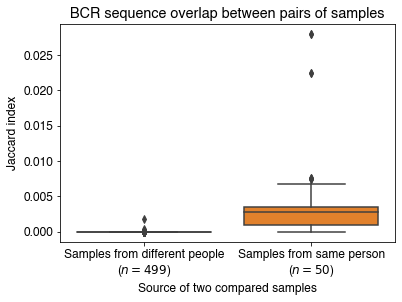

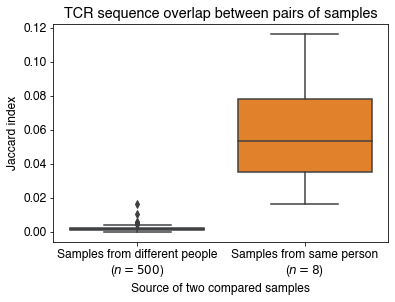

In [6]:
# Plot:
# Loop over gene loci
for gene_locus in config.gene_loci_used:
    # Reload
    comparison = pd.read_csv(
        config.paths.output_dir
        / f"sequence_overlap_between_samples.{gene_locus.name}.tsv",
        sep="\t",
    )

    fig, ax = plt.subplots()
    sns.boxplot(x="type", y="jaccard_index", data=comparison, ax=ax)
    plt.title(f"{gene_locus.name} sequence overlap between pairs of samples")
    plt.xlabel("Source of two compared samples")
    plt.ylabel("Jaccard index")
    ax.set_xticklabels(
        genetools.plots.add_sample_size_to_labels(
            ax.get_xticklabels(), comparison, "type"
        )
    )

    genetools.plots.savefig(
        fig,
        config.paths.output_dir
        / f"sequence_overlap_between_samples.{gene_locus.name}.png",
        dpi=300,
    )

    selection = comparison[comparison["type"] == "Samples from same person"]
    selection = set(selection["specimen1"].str.split("-").str[0]).union(
        set(selection["specimen2"].str.split("-").str[0])
    )
    print(
        f"{gene_locus}: these runs have participants with multiple samples: {selection}"
    )
    print()

    study_name_per_specimen = helpers.get_all_specimen_info().set_index(
        "specimen_label"
    )["study_name"]
    for key, grp in comparison.groupby("type"):
        vals = grp["jaccard_index"] * 100  # convert to percent
        cohorts_involved = set(
            study_name_per_specimen.loc[comparison["specimen1"]]
        ) | set(study_name_per_specimen.loc[comparison["specimen2"]])
        print(
            f"{gene_locus}, {key}: Avg +/- std of Jaccard index = {vals.mean():0.3f} +/- {vals.std():0.3f} %. n={vals.shape[0]} pairs of samples, from cohorts: {cohorts_involved}"
        )
        print()